<a href="https://colab.research.google.com/github/maperezp/Proyecto-DL-Grupo4/blob/main/model/Modelo_para_la_deteccion_estadios_de_Fibrosis_Hepatica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalar Kaggle Lybrary
!pip install kaggle

# Cargar kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cristianbordab","key":"6befde7405e813addcc2533ccab27856"}'}

In [ ]:
# Crear directorio para la configuración de Kaggle
!mkdir -p ~/.kaggle

# Mover kaggle.json al directorio creado anteriormente
!mv kaggle.json ~/.kaggle/

# Setear permisos
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Descargar el dataset a usar desde Kaggle
!kaggle datasets download -d vibhingupta028/liver-histopathology-fibrosis-ultrasound-images
# Desempaquetar Dataset
!unzip liver-histopathology-fibrosis-ultrasound-images.zip -d ./liver_dataset

Streaming output truncated to the last 5000 lines.
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7378.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a738.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7384.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7405.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a741.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7410.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7412.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7415.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7425.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7431.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7435.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7446.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7448.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7460.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7464.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a74

In [ ]:
#Importar librerias necesarias
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import cohen_kappa_score


import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model


from sklearn.utils import class_weight

from tensorflow.keras.models import load_model

## Preparación de datos

Total imagenes: 6323
Conjunto de training: 4046 imagenes
Conjunto de testing: 1265 imagenes
Conjunto de validación: 1012 imagenes


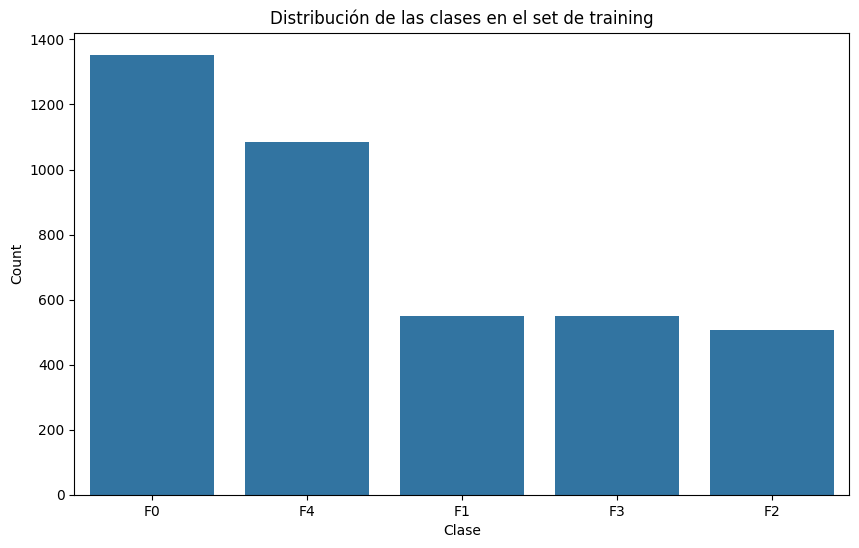

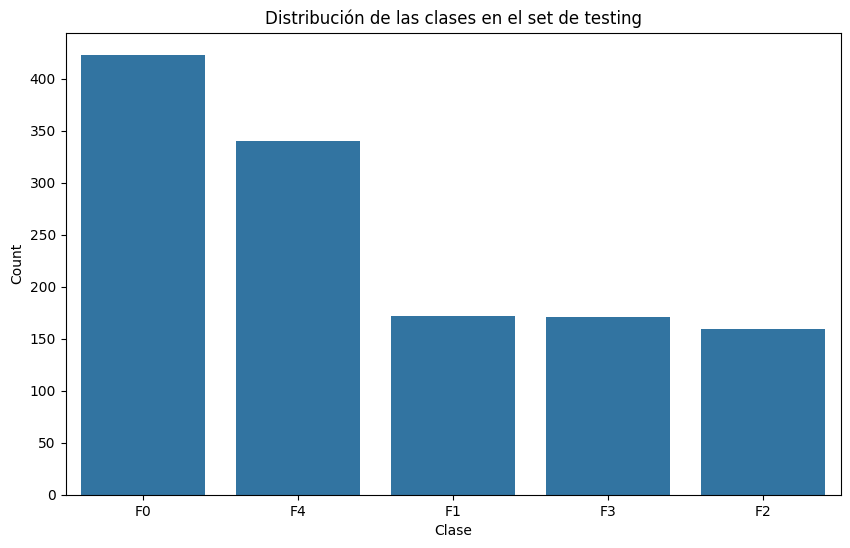

In [ ]:
# Definir la ubicación de las imagenes del dataset
image_folder = './liver_dataset/Dataset/Dataset/'

# Crear la lista para los estados de la Fibrosis a analizar
class_labels = ['F0', 'F1', 'F2', 'F3', 'F4']

# Listas vacias para almacenar ubicación y etiquetas de imagenes
image_paths = []
labels = []

for label in class_labels:
    class_folder = os.path.join(image_folder, label)
    for img_name in os.listdir(class_folder):
        image_paths.append(os.path.join(class_folder, img_name))
        labels.append(label)

# Creación Dataframe
data = pd.DataFrame({'Image_Path': image_paths, 'Label': labels})

# Separar conjuntos de training y testing
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['Label'], random_state=42, shuffle = True)

# Ahora dividir el conjunto de entrenamiento: en entrenamiento y validación
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['Label'], random_state=42, shuffle = True)

# Validar la separación de entrenamiento y testing
print(f"Total imagenes: {len(data)}")
print(f"Conjunto de training: {len(train_data)} imagenes")
print(f"Conjunto de testing: {len(test_data)} imagenes")
print(f"Conjunto de validación: {len(val_data)} imagenes")

# Graficar como quedo la distribución de clases para training y testing
def plot_class_distribution(data, title):
    class_counts = data['Label'].value_counts().reset_index()
    class_counts.columns = ['Class', 'Count']
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Count', data=class_counts)
    plt.title(title)
    plt.xlabel('Clase')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution(train_data, "Distribución de las clases en el set de training")
plot_class_distribution(test_data, "Distribución de las clases en el set de testing")

In [ ]:
train_data

,Image_Path,Label
6184,./liver_dataset/Dataset/Dataset/F4/e34.jpg,F4
5537,./liver_dataset/Dataset/Dataset/F4/ct15-31.png,F4
4430,./liver_dataset/Dataset/Dataset/F3/U3046.jpg,F3
1460,./liver_dataset/Dataset/Dataset/F0/a6455.jpg,F0
3248,./liver_dataset/Dataset/Dataset/F2/ct4-78.png,F2
...,...,...
1752,./liver_dataset/Dataset/Dataset/F0/a2246.jpg,F0
4509,./liver_dataset/Dataset/Dataset/F3/ct12-35.png,F3
4138,./liver_dataset/Dataset/Dataset/F3/ct9-57.png,F3
2617,./liver_dataset/Dataset/Dataset/F1/b24.jpg,F1


In [ ]:
# Ubicación imagen ejemplo
image_path = "./liver_dataset/Dataset/Dataset/F1/h2767.jpg"

# Abrir la imagen
image = Image.open(image_path)

#Convertir la imagen a un array
image_array = np.array(image)

# obtención de dimensiones
height, width = image_array.shape[:2]  # alto y ancho
channels = 1 if len(image_array.shape) == 2 else image_array.shape[2]  # validar escala de grises

print(f"Dimensiones Imagen: {width}x{height}")
print(f"Numero de canales: {channels}")

Dimensiones Imagen: 640x480
Numero de canales: 1


## Entrenamiento sin aumentación

In [ ]:
# Carga de imagenes y etiquetas
def load_images_and_labels_from_dataframe(dataframe, image_size=(224, 224)):
    images = []
    labels = []
    class_names = sorted(dataframe['Label'].unique())
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}

    for _, row in dataframe.iterrows():
        img_path = row['Image_Path']
        label = row['Label']
        img = Image.open(img_path)

        # Validar si la imagen esta en escala de grises, si no convertir a RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        img = img.resize(image_size)
        img_array = np.array(img)

        # Agregar imagen y su etiqueta
        images.append(img_array)
        labels.append(class_indices[label])

    return np.array(images), np.array(labels), class_indices

# Carga de imagenes y etiquetas
image_size = (224, 224)  # reconfigurar el tamaño de las imagenes a 224x224
X_train, y_train, class_indices = load_images_and_labels_from_dataframe(train_data, image_size=image_size)
X_val, y_val, _ = load_images_and_labels_from_dataframe(val_data, image_size=image_size)
X_test, y_test, _ = load_images_and_labels_from_dataframe(test_data, image_size=image_size)

# Normalización de imagenes
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Número de clases e indices respectivos
num_classes = len(class_indices)
print(f"Clases: {class_indices}")
print(f"Número de clases: {num_classes}")


Clases: {'F0': 0, 'F1': 1, 'F2': 2, 'F3': 3, 'F4': 4}
Número de clases: 5


In [ ]:
# Calcular los pesos inversos
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train), # y_train contiene las etiquetas numéricas (0, 1, 2, 3, 4)
    y=y_train
)

# Convertir el array a un diccionario (formato que espera Keras)
class_weights_dict = dict(enumerate(class_weights))

print("Pesos de Clase Calculados (Clase: Peso):")
print(class_weights_dict)

#Los pesos de F1, F2 y F3 seran mayores que F0 y F4.

Pesos de Clase Calculados (Clase: Peso):
{0: np.float64(0.5980783444198078), 1: np.float64(1.4686025408348458), 2: np.float64(1.5960552268244577), 3: np.float64(1.473952641165756), 4: np.float64(0.7451197053406998)}


In [ ]:
X_train.shape
y_train.shape

(4046,)

## Aumentación de imagenes

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

## Creación del modelo a partir de una Red Neuronal Convolucional (CNN)

In [ ]:
# Define el valor del factor de regularización
l2_factor = 0.001

model = Sequential([
    Conv2D(40, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(l2_factor)),
    Conv2D(40, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(l2_factor)),
    Conv2D(40, kernel_size=(4, 4), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(l2_factor)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Conv2D(70, kernel_size=(2, 2), activation='relu', kernel_regularizer=regularizers.l2(l2_factor)),
    Conv2D(70, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_factor)),
    Conv2D(70, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(l2_factor)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_factor)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compilación del modelo
model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 223, 223, 40)   │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 221, 221, 40)   │        14,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 218, 218, 40)   │        25,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 109, 109, 40)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 109, 109, 40)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 108, 108, 70)   │        11,270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 106, 106, 70)   │        44,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 103, 103, 70)   │        78,470 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 51, 51, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 51, 51, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 182070)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    23,305,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,480,243 (89.57 MB)

 Trainable params: 23,480,243 (89.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=5, shuffle=True),
                    steps_per_epoch=len(X_train) // 5,
                    epochs=200,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


809/809 ━━━━━━━━━━━━━━━━━━━━ 57s 62ms/step - accuracy: 0.3783 - loss: 1.6284 - val_accuracy: 0.4605 - val_loss: 1.1958
Epoch 2/200
  1/809 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.4000 - loss: 1.2601

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4000 - loss: 1.2601 - val_accuracy: 0.4664 - val_loss: 1.1972
Epoch 3/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.4456 - loss: 1.2397 - val_accuracy: 0.4713 - val_loss: 1.1722
Epoch 4/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6000 - loss: 0.9442 - val_accuracy: 0.4704 - val_loss: 1.1731
Epoch 5/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.4644 - loss: 1.2129 - val_accuracy: 0.4565 - val_loss: 1.1666
Epoch 6/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4000 - loss: 1.5632 - val_accuracy: 0.4565 - val_loss: 1.1642
Epoch 7/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.4652 - loss: 1.1823 - val_accuracy: 0.4960 - val_loss: 1.1447
Epoch 8/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6000 - loss: 1.2450 - val_accuracy: 0.4921 - val_loss: 1.1439
Epoch 9/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.4686 - loss: 1.2034 - val_accuracy

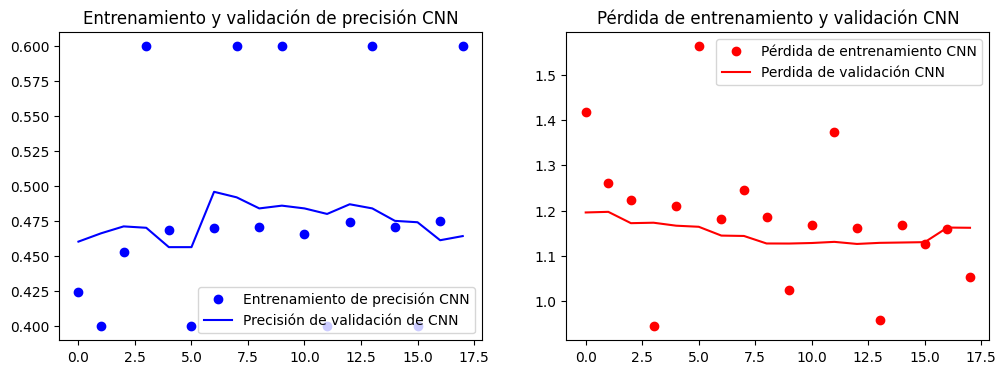

In [ ]:
acc_vgg = history.history['accuracy']
val_acc_vgg = history.history['val_accuracy']
loss_vgg = history.history['loss']
val_loss_vgg = history.history['val_loss']
epochs = range(len(acc_vgg))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_vgg, 'bo', label='Entrenamiento de precisión CNN')
plt.plot(epochs, val_acc_vgg, 'b', label='Precisión de validación de CNN')
plt.title('Entrenamiento y validación de precisión CNN')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_vgg, 'ro', label='Pérdida de entrenamiento CNN')
plt.plot(epochs, val_loss_vgg, 'r', label='Perdida de validación CNN')
plt.title('Pérdida de entrenamiento y validación CNN')
plt.legend()

plt.show()

## Resultados Modelo con Training set



In [ ]:
y_pred = model.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_train, y_pred))

127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step
              precision    recall  f1-score   support

           0       0.64      0.99      0.78      1353
           1       0.00      0.00      0.00       551
           2       0.19      0.02      0.04       507
           3       0.30      0.99      0.47       549
           4       0.49      0.05      0.10      1086

    accuracy                           0.48      4046
   macro avg       0.32      0.41      0.28      4046
weighted avg       0.41      0.48      0.36      4046



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Resultados Modelo con testing set

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       423
           1       0.00      0.00      0.00       172
           2       0.24      0.03      0.06       159
           3       0.31      1.00      0.47       171
           4       0.45      0.06      0.10       340

    accuracy                           0.49      1265
   macro avg       0.33      0.42      0.28      1265
weighted avg       0.41      0.49      0.36      1265



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


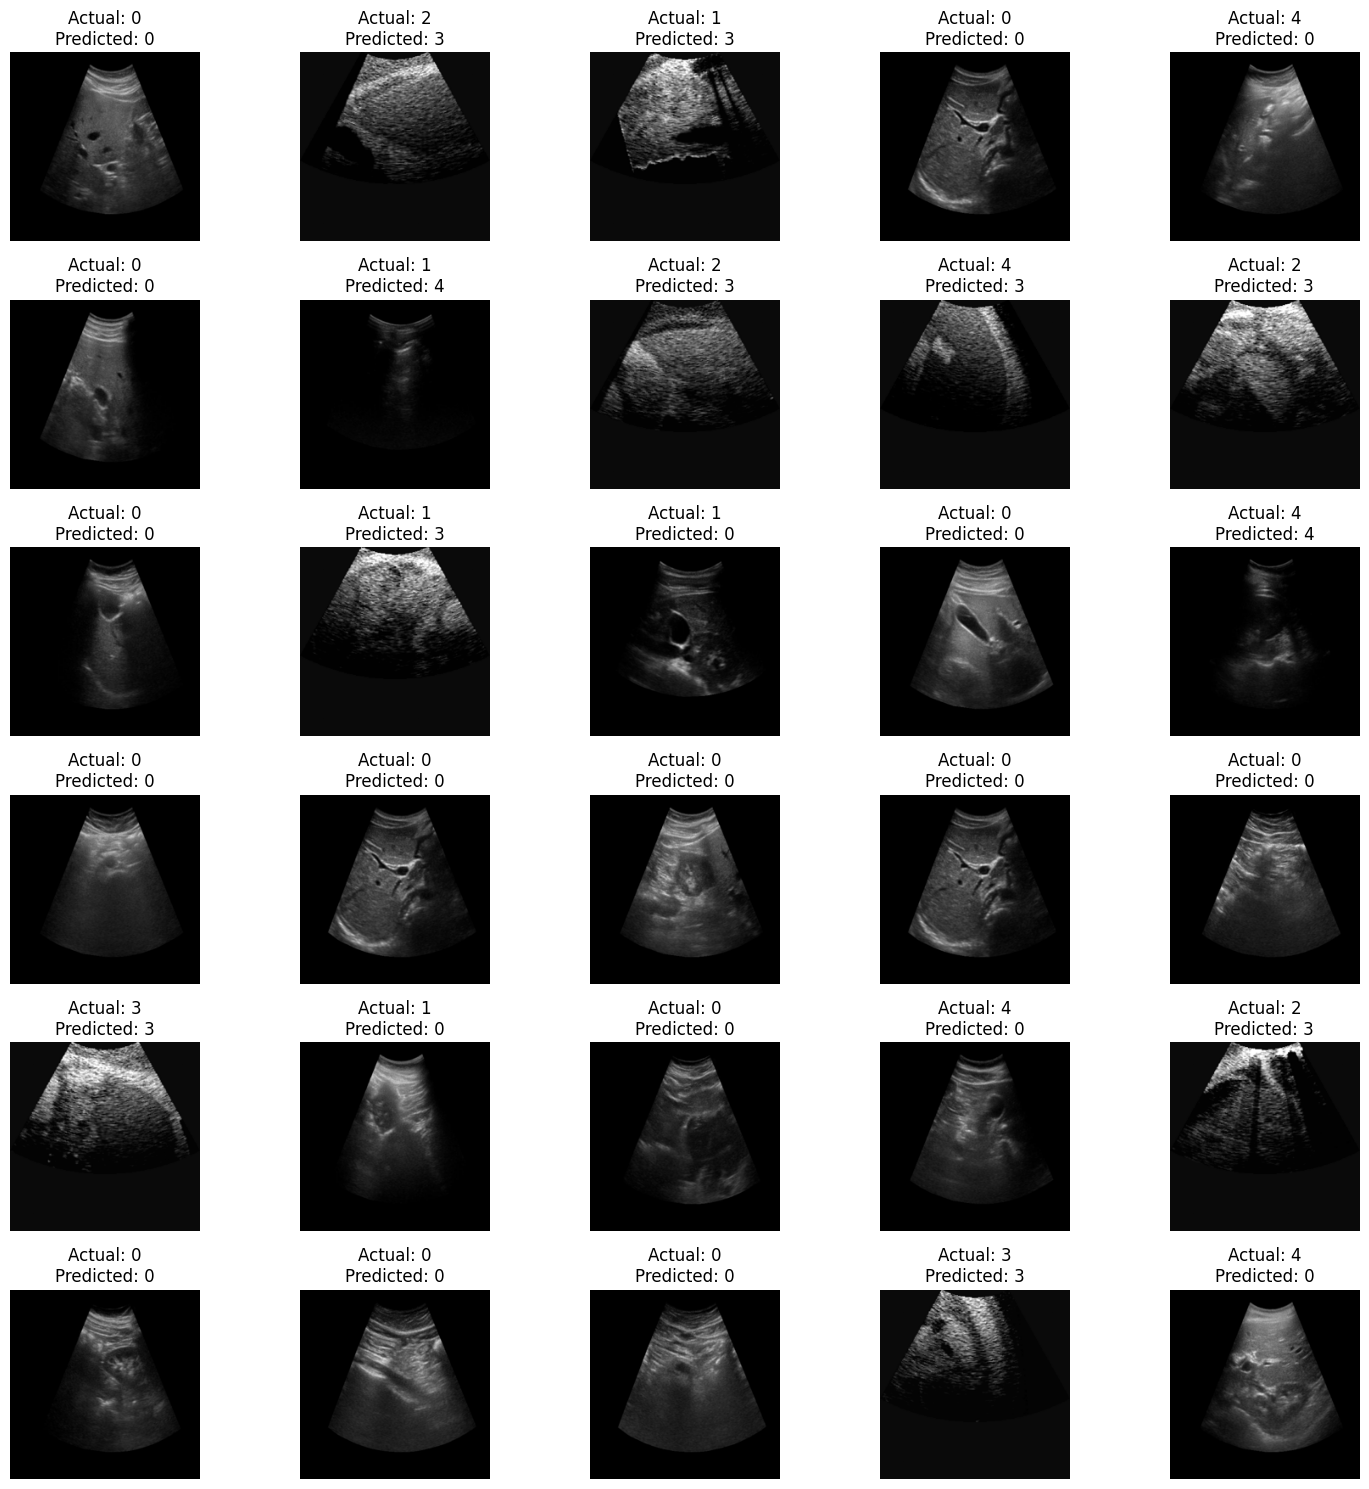

In [ ]:
# Make predictions on the validation set
y_pred = model.predict(X_test)

# Get the predicted class labels (for sparse categorical crossentropy, we use argmax)
y_pred_labels = np.argmax(y_pred, axis=1)

# Randomly select 30 images and their corresponding labels
num_images = 30
random_indices = np.random.choice(X_test.shape[0], num_images, replace=False)

# Set up the plot
plt.figure(figsize=(15, 15))

# Loop over the selected random indices to plot the images
for i, idx in enumerate(random_indices):
    plt.subplot(6, 5, i+1)  # 6 rows, 5 columns
    img = X_test[idx].squeeze()  # Remove the channel dimension if it's there
    actual_label = y_test[idx]
    predicted_label = y_pred_labels[idx]

    # Plot the image
    plt.imshow(img, cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis('off')  # Turn off axes

    # Set the title with the actual and predicted labels
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()

## Resultados del modelo CNN

* F0 y F3 (clases cominantes): Tienen un recall cercano al 1.00, lo que significa que el modelo está sobre-prediciendo estas dos clases. De hecho, el modelo solo está aprendiendo a distinguir entre 2 o 3 categorías de manera efectiva.

* F1, F2, F4 (clases críticas): El recall para estas clases es cercano a 0.00 (excepto F2 en el test set con 0.03 y F4 con 0.06). Confirma que el modelo no ha aprendido a identificar la mayoría de los casos reales de fibrosis intermedia o avanzada.

* Accuracy global: Bajo, alrededor de 0.48

* Pérdida de entrenamiento (Puntos rojos): Es extremadamente ruidosa, saltando de 1.4 a 0.95 en cuestión de una o dos épocas.

* Precisión de entrenamiento (Puntos azules): Muestra picos y valles, lo que indica que el optimizador tiene dificultades para encontrar una dirección estable.

## Conclusión
La inestabilidad y el bajo rendimiento persisten. El problema fundamental no es de hiperparámetros, sino que la arquitectura CNN, entrenada desde cero, es demasiado compleja para ser entrenada con la cantidad de datos disponibles.



## ------------------------------------------------------------------------------

## Modelo VGG 16 con Fine Tuning

In [ ]:
conv_base_vgg = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Congelar capas del modelo pre-entrenado
conv_base_vgg.trainable = False

# Descongerlar ultimas capas para fine tuning
for layer in conv_base_vgg.layers[-4:]:
    layer.trainable = True

print("Capas entrenables en VGG16:")
for layer in conv_base_vgg.layers:
    print(f"{layer.name}: {'Entrenable' if layer.trainable else 'No entrenable'}")

Capas entrenables en VGG16:
input_layer: No entrenable
block1_conv1: No entrenable
block1_conv2: No entrenable
block1_pool: No entrenable
block2_conv1: No entrenable
block2_conv2: No entrenable
block2_pool: No entrenable
block3_conv1: No entrenable
block3_conv2: No entrenable
block3_conv3: No entrenable
block3_pool: No entrenable
block4_conv1: No entrenable
block4_conv2: No entrenable
block4_conv3: No entrenable
block4_pool: No entrenable
block5_conv1: Entrenable
block5_conv2: Entrenable
block5_conv3: Entrenable
block5_pool: Entrenable


In [ ]:
model_vgg = models.Sequential()
model_vgg.add(conv_base_vgg)  # Añadir VGG16 como base
model_vgg.add(layers.Flatten())  # Aplanamiento de la salida convolucional
model_vgg.add(layers.Dense(128, activation='relu'))  # Capa densa con ReLU
model_vgg.add(layers.Dropout(0.3))  # Capa de Dropout para la regularizacion
model_vgg.add(layers.Dense(5, activation='softmax'))

In [ ]:
# Difiniendo el Callback Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitorear accuracy
    patience=4,              # Detenerse despues de 4 epochs sin mejoras
    restore_best_weights=True  # Restaurar pesos del mejor modelo
)

# Compilar el modelo con el optimizador RMSprop
model_vgg.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),  # Baja tasa de aprendizaje para el fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Imprimir el resumen del modelo para ver arquitectura
model_vgg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,725 (68.39 MB)

 Trainable params: 10,291,461 (39.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Entrenamiento del modelo

In [ ]:
history_vgg = model_vgg.fit(
    X_train, y_train,
    epochs=50,
    batch_size=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.3813 - loss: 1.4197 - val_accuracy: 0.5049 - val_loss: 1.0659
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 480ms/step - accuracy: 0.5316 - loss: 1.0718 - val_accuracy: 0.6759 - val_loss: 0.9215
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 480ms/step - accuracy: 0.6299 - loss: 0.9129 - val_accuracy: 0.6937 - val_loss: 0.8267
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 481ms/step - accuracy: 0.6655 - loss: 0.8318 - val_accuracy: 0.6354 - val_loss: 0.8181
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 480ms/step - accuracy: 0.7001 - loss: 0.7595 - val_accuracy: 0.7134 - val_loss: 0.7165
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 481ms/step - accuracy: 0.7130 - loss: 0.7191 - val_accuracy: 0.7312 - val_loss: 0.7094
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 477ms/step - accuracy: 0.7369 - loss: 0.6763 - val_accuracy: 0.7125 - val_loss: 0.6807
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 477ms/step - accuracy: 0.7546 - loss: 0.6436 - val_accurac

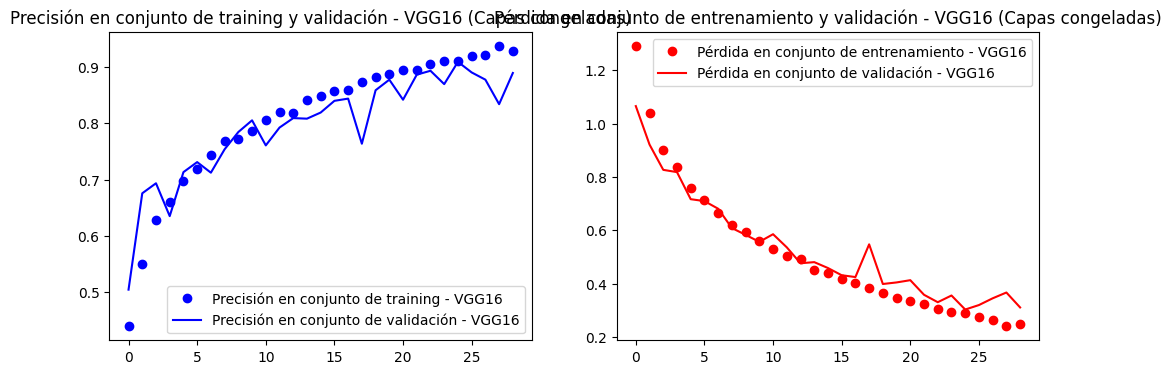

In [ ]:
acc_vgg = history_vgg.history['accuracy']
val_acc_vgg = history_vgg.history['val_accuracy']
loss_vgg = history_vgg.history['loss']
val_loss_vgg = history_vgg.history['val_loss']
epochs = range(len(acc_vgg))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_vgg, 'bo', label='Precisión en conjunto de training - VGG16')
plt.plot(epochs, val_acc_vgg, 'b', label='Precisión en conjunto de validación - VGG16')
plt.title('Precisión en conjunto de training y validación - VGG16 (Capas congeladas)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_vgg, 'ro', label='Pérdida en conjunto de entrenamiento - VGG16')
plt.plot(epochs, val_loss_vgg, 'r', label='Pérdida en conjunto de validación - VGG16')
plt.title('Pérdida en conjunto de entrenamiento y validación - VGG16 (Capas congeladas)')
plt.legend()

plt.show()

## Resultados Modelo con Training set

In [ ]:
y_pred = model_vgg.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_train, y_pred))

127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1353
           1       0.92      0.87      0.89       551
           2       0.83      0.91      0.87       507
           3       0.94      0.91      0.93       549
           4       0.97      0.96      0.97      1086

    accuracy                           0.95      4046
   macro avg       0.93      0.93      0.93      4046
weighted avg       0.95      0.95      0.95      4046



## Resultados Modelo con testing set

In [ ]:
y_pred = model_vgg.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       423
           1       0.78      0.69      0.73       172
           2       0.67      0.79      0.72       159
           3       0.78      0.79      0.78       171
           4       0.96      0.92      0.94       340

    accuracy                           0.88      1265
   macro avg       0.84      0.84      0.83      1265
weighted avg       0.88      0.88      0.88      1265



40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


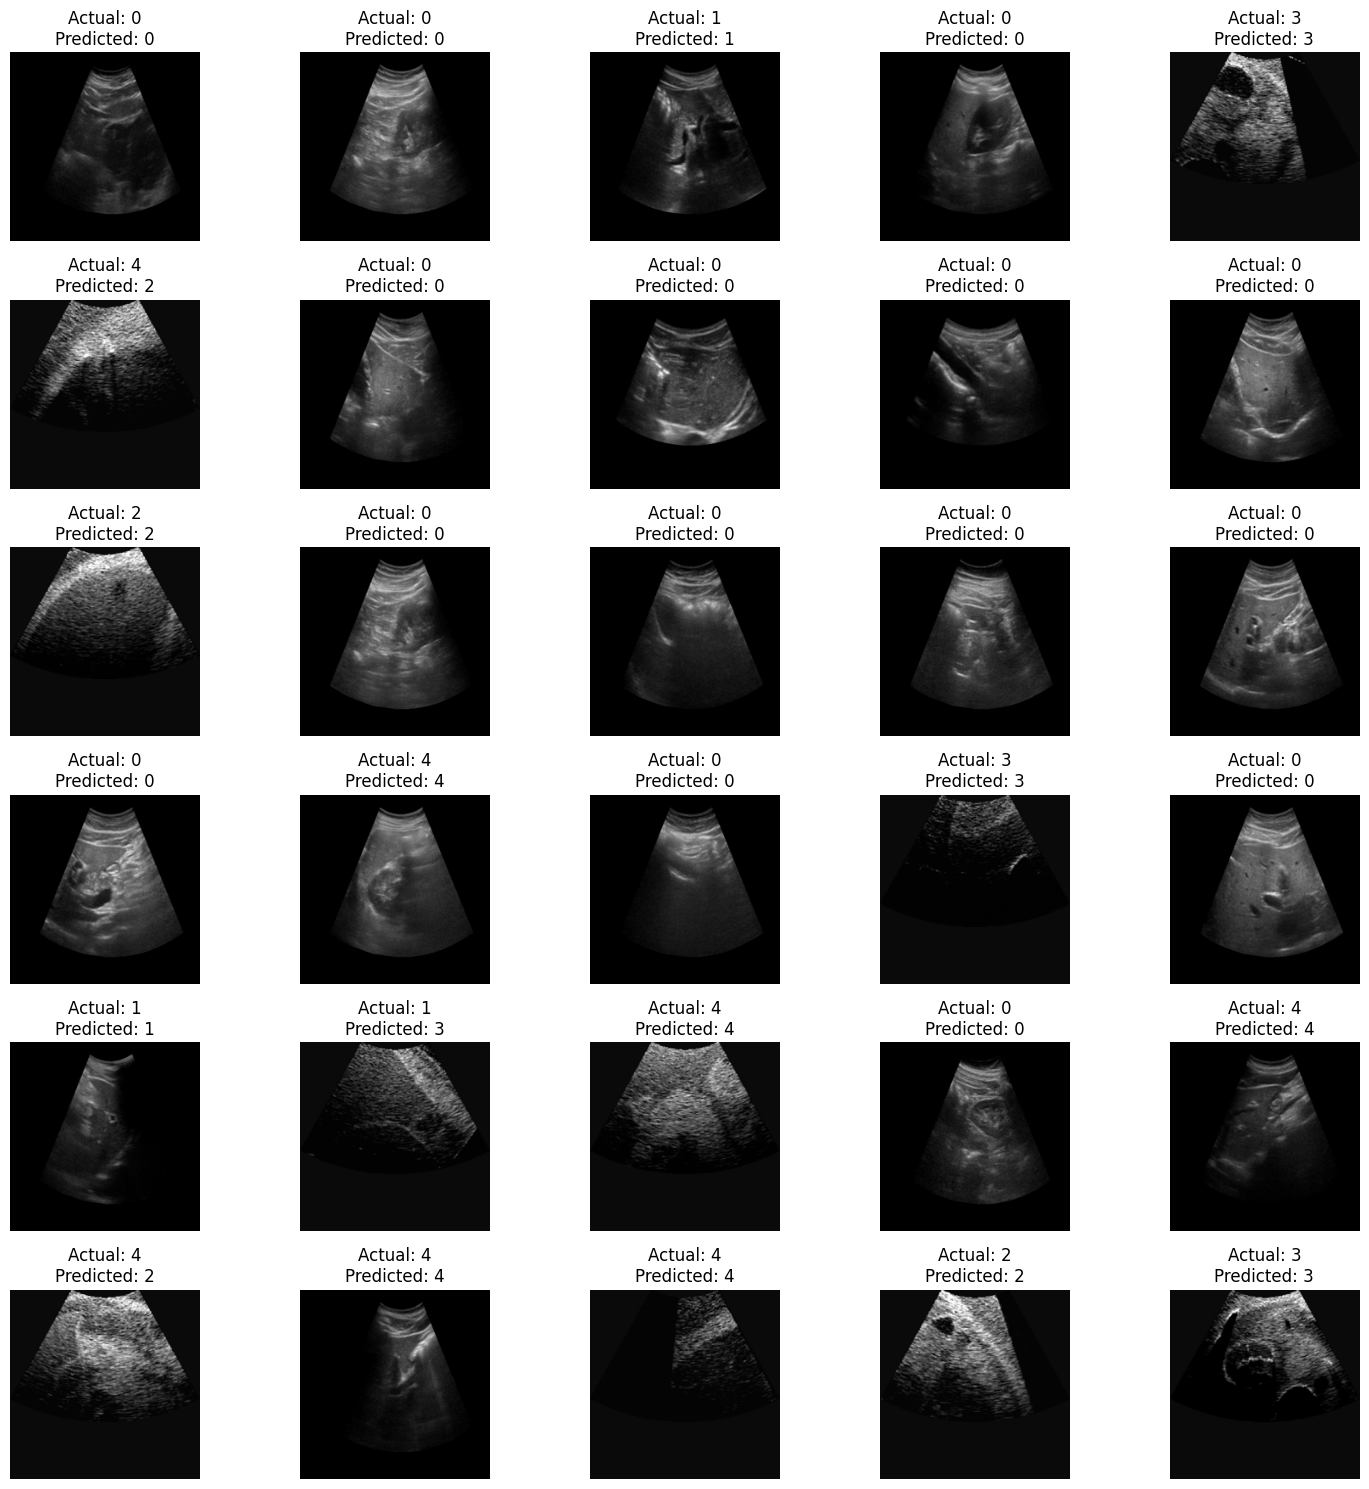

In [ ]:
# Hacer predicciones sobre el conjunto de testing
y_pred = model_vgg.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)

num_images = 30
random_indices = np.random.choice(X_test.shape[0], num_images, replace=False)

plt.figure(figsize=(15, 15))

# Loop para graficar imagenes
for i, idx in enumerate(random_indices):
    plt.subplot(6, 5, i+1)  # 6 filas, 5 columnas
    img = X_test[idx].squeeze()
    actual_label = y_test[idx]
    predicted_label = y_pred_labels[idx]

    # Dibujar imagen
    plt.imshow(img, cmap='gray')  # Usar 'gray' para imagenes en escala de grises
    plt.axis('off')

    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()

## Resultados del Modelo VGG 16 con Fine Tuning

* El modelo alcanza un 88% de precisión en el conjunto de prueba. Este valor es sólido y está alineado con las expectativas de un modelo de transfer learning en un entorno médico.

* Estabilidad: Los promedios macro (0.84) y ponderado (0.88) son muy cercanos, indicando que el modelo tiene un buen rendimiento generalizado en todas las clases, sin estar tan sesgado por las clases grandes.

* Generalización: La diferencia de precisión entre el entrenamiento (≈0.95) y la prueba (≈0.88) es de solo 7 puntos porcentuales, lo que indica un sobreajuste leve y manejable.

**Análisis por clases**

* F0 (Ausencia cirrosis): El modelo casi nunca diagnostica erróneamente a un paciente sano, lo cual minimiza los estudios invasivos innecesarios.

* F2 (Intermedia): El Recall (0.79) es alto, lo que significa que el modelo identifica la mayoría de los casos reales de F2. Sin embargo, la Precisión (0.67) es baja, lo que indica que 33% de las veces que el modelo predice F2, se equivoca (son falsos positivos).

* F4 (Cirrosis): Alta capacidad para detectar el estadio terminal.

## Conclusiones

1. Se valida la hipótesis de que el Transfer Learning es el enfoque metodológico superior para la clasificación de fibrosis hepática a partir de imágenes ecográficas con datasets limitados.
2. El modelo demuestra una capacidad prometedora para la detección temprana de fibrosis (F2 y F3). El alto recall en F2 (0.79) indica que la herramienta puede identificar a casi 8 de cada 10 pacientes en riesgo, cumpliendo con el objetivo de identificación oportuna.
3. La baja precisión en F2 (0.67) y F1 (0.78) sugiere que el modelo todavía tiene dificultades para distinguir las diferencias sutiles entre los estadios intermedios.




## -----------------------------------------------------------------------------

## Modelo Resnet 50 con Fine tuning

In [ ]:
# Carga de imagenes y etiquetas
image_size = (224, 224)  # reconfigurar el tamaño de las imagenes a 224x224
X_train, y_train, class_indices = load_images_and_labels_from_dataframe(train_data, image_size=image_size)
X_val, y_val, _ = load_images_and_labels_from_dataframe(val_data, image_size=image_size)
X_test, y_test, _ = load_images_and_labels_from_dataframe(test_data, image_size=image_size)

# No se normalizan las imagenes, ResNet tiene una función de preprocesamiento asociada a la arquitectura

# Número de clases e indices respectivos
num_classes = len(class_indices)
print(f"Clases: {class_indices}")
print(f"Número de clases: {num_classes}")

Clases: {'F0': 0, 'F1': 1, 'F2': 2, 'F3': 3, 'F4': 4}
Número de clases: 5


In [ ]:
conv_base_resnet = ResNet50(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3))

In [ ]:
# Congelar capas
conv_base_resnet.trainable = False

# Descongelar ciertas capas (ultimas 20)
for layer in conv_base_resnet.layers[-20:]:
    layer.trainable = True

print("Capas entrenables en ResNet50:")
for layer in conv_base_resnet.layers:
    print(f"{layer.name}: {'Entrenable' if layer.trainable else ''}")


Capas entrenables en ResNet50:
input_layer_5: 
conv1_pad: 
conv1_conv: 
conv1_bn: 
conv1_relu: 
pool1_pad: 
pool1_pool: 
conv2_block1_1_conv: 
conv2_block1_1_bn: 
conv2_block1_1_relu: 
conv2_block1_2_conv: 
conv2_block1_2_bn: 
conv2_block1_2_relu: 
conv2_block1_0_conv: 
conv2_block1_3_conv: 
conv2_block1_0_bn: 
conv2_block1_3_bn: 
conv2_block1_add: 
conv2_block1_out: 
conv2_block2_1_conv: 
conv2_block2_1_bn: 
conv2_block2_1_relu: 
conv2_block2_2_conv: 
conv2_block2_2_bn: 
conv2_block2_2_relu: 
conv2_block2_3_conv: 
conv2_block2_3_bn: 
conv2_block2_add: 
conv2_block2_out: 
conv2_block3_1_conv: 
conv2_block3_1_bn: 
conv2_block3_1_relu: 
conv2_block3_2_conv: 
conv2_block3_2_bn: 
conv2_block3_2_relu: 
conv2_block3_3_conv: 
conv2_block3_3_bn: 
conv2_block3_add: 
conv2_block3_out: 
conv3_block1_1_conv: 
conv3_block1_1_bn: 
conv3_block1_1_relu: 
conv3_block1_2_conv: 
conv3_block1_2_bn: 
conv3_block1_2_relu: 
conv3_block1_0_conv: 
conv3_block1_3_conv: 
conv3_block1_0_bn: 
conv3_block1_3_bn: 
c

In [ ]:
x = conv_base_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', name='dense_512')(x)
x = Dropout(0.3)(x)
predictions = Dense(5, activation='softmax', name='predictions')(x)

model_resnet = Model(inputs=conv_base_resnet.input, outputs=predictions)

In [ ]:
# Definir el callback Early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    restore_best_weights=True
)

# Compile the model with RMSprop optimizer
model_resnet.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),  # Tasa pequeña de aprendizaje para fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']  #
)

# Arquitectura y resumen del modelo
model_resnet.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 9,982,981 (38.08 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

## Entrenamiento del modelo

In [ ]:
history_resnet = model_resnet.fit(
    X_train, y_train,
    epochs=50,
    batch_size=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 973ms/step - accuracy: 0.5649 - loss: 1.0775 - val_accuracy: 0.6117 - val_loss: 0.9862
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.8646 - loss: 0.3639 - val_accuracy: 0.7885 - val_loss: 0.5256
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.9597 - loss: 0.1405 - val_accuracy: 0.7372 - val_loss: 0.9237
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - accuracy: 0.9793 - loss: 0.0714 - val_accuracy: 0.8231 - val_loss: 0.5946
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - accuracy: 0.9974 - loss: 0.0190 - val_accuracy: 0.8458 - val_loss: 0.4744
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - accuracy: 0.9965 - loss: 0.0163 - val_accuracy: 0.8992 - val_loss: 0.3870
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.9973 - loss: 0.0119 - val_accuracy: 0.9545 - val_loss: 0.1824
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0

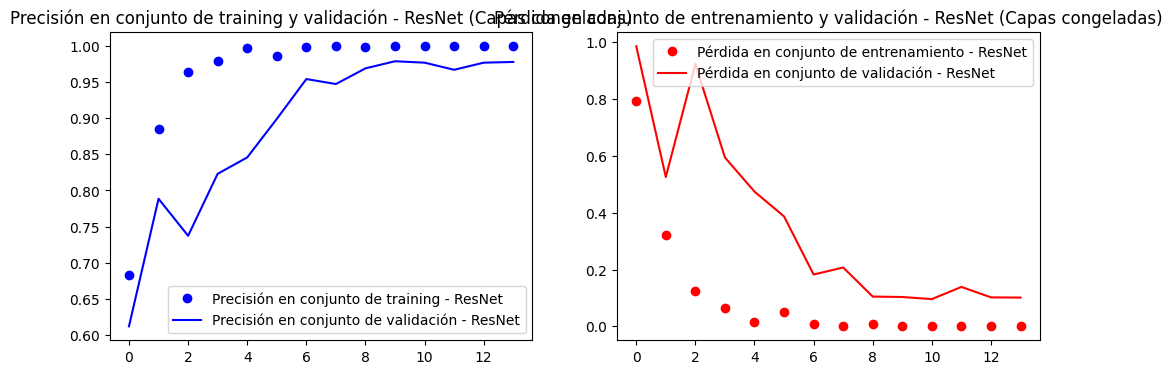

In [ ]:
acc_vgg = history_resnet.history['accuracy']
val_acc_vgg = history_resnet.history['val_accuracy']
loss_vgg = history_resnet.history['loss']
val_loss_vgg = history_resnet.history['val_loss']
epochs = range(len(acc_vgg))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_vgg, 'bo', label='Precisión en conjunto de training - ResNet')
plt.plot(epochs, val_acc_vgg, 'b', label='Precisión en conjunto de validación - ResNet')
plt.title('Precisión en conjunto de training y validación - ResNet (Capas congeladas)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_vgg, 'ro', label='Pérdida en conjunto de entrenamiento - ResNet')
plt.plot(epochs, val_loss_vgg, 'r', label='Pérdida en conjunto de validación - ResNet')
plt.title('Pérdida en conjunto de entrenamiento y validación - ResNet (Capas congeladas)')
plt.legend()

plt.show()

## Resultados Modelo con Training set

In [ ]:
y_pred = model_resnet.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_train, y_pred))

127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1353
           1       1.00      1.00      1.00       551
           2       1.00      1.00      1.00       507
           3       1.00      1.00      1.00       549
           4       1.00      1.00      1.00      1086

    accuracy                           1.00      4046
   macro avg       1.00      1.00      1.00      4046
weighted avg       1.00      1.00      1.00      4046



## Resultados Modelo con testing set

In [ ]:
y_pred = model_resnet.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       423
           1       0.99      0.88      0.93       172
           2       0.89      0.93      0.91       159
           3       0.92      0.92      0.92       171
           4       0.97      1.00      0.99       340

    accuracy                           0.96      1265
   macro avg       0.95      0.95      0.95      1265
weighted avg       0.97      0.96      0.96      1265



40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


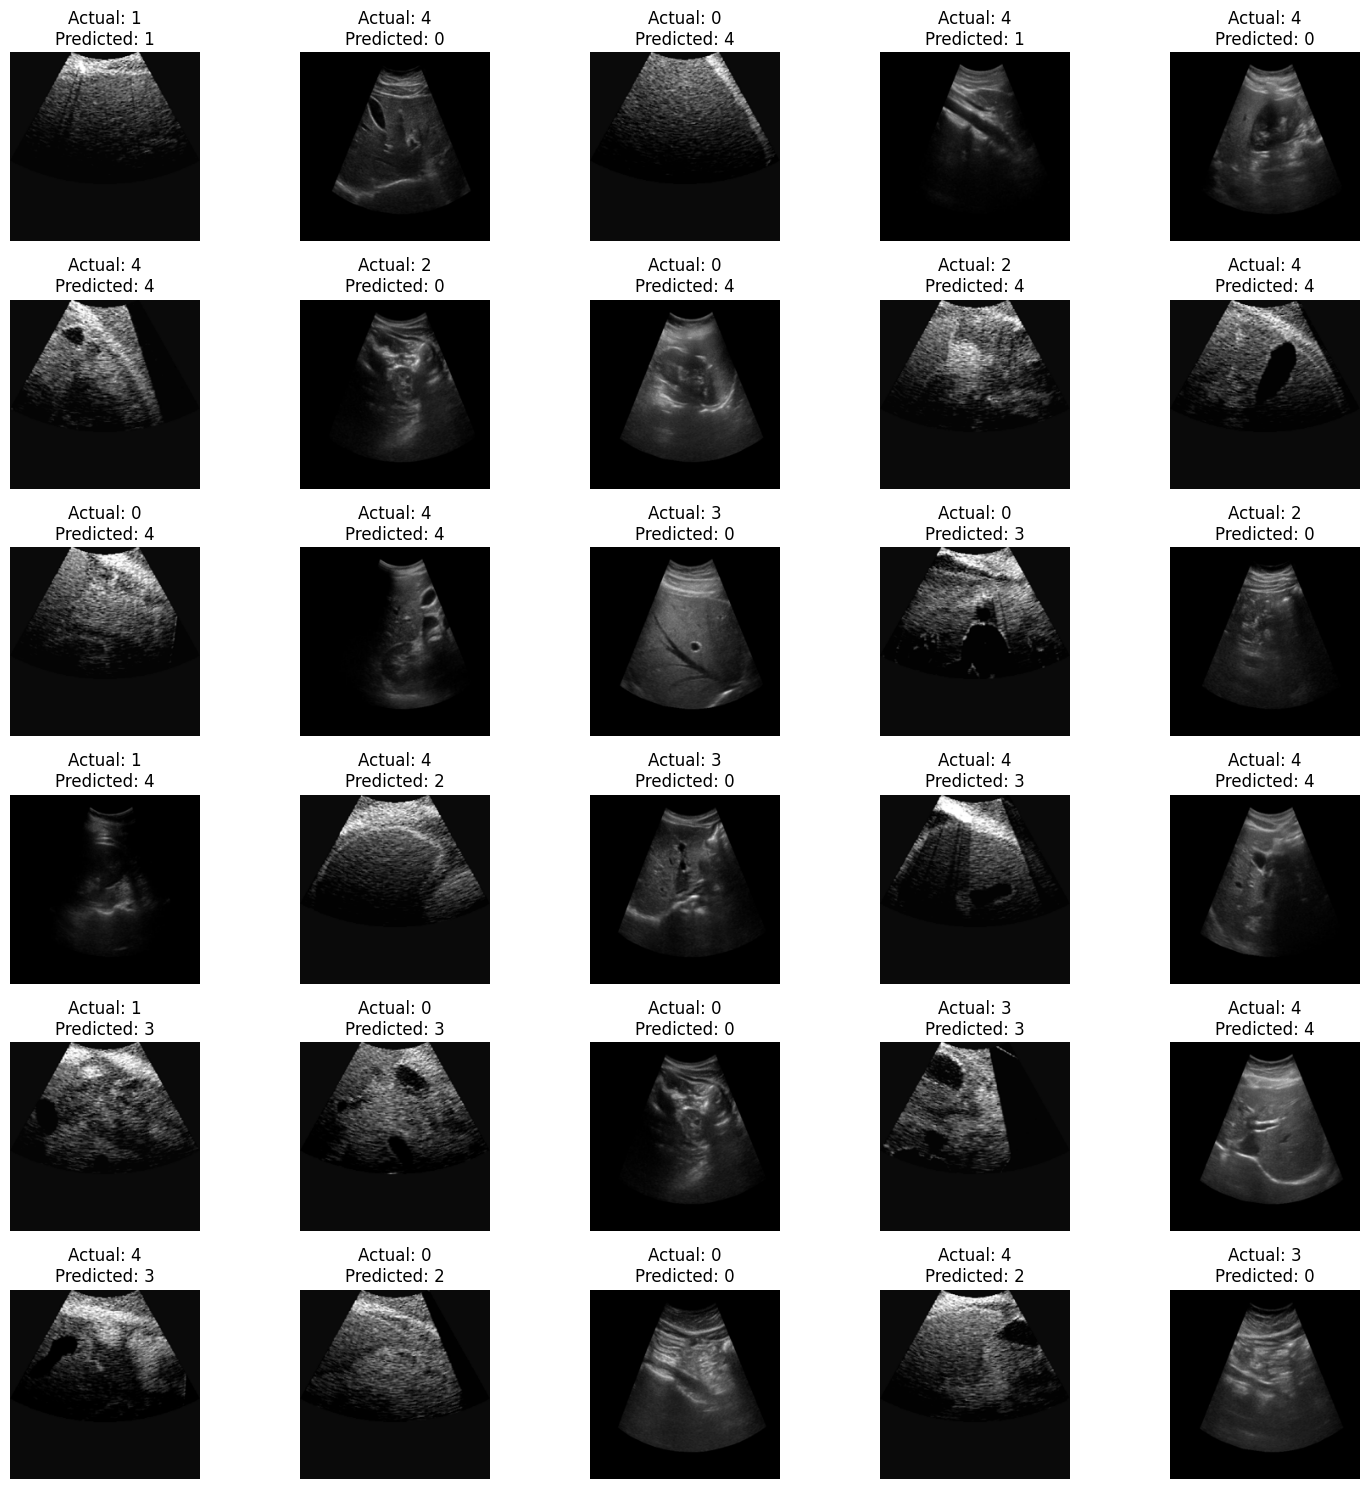

In [ ]:
# Hacer predicciones sobre el conjunto de testing
y_pred = model_resnet.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)

num_images = 30
random_indices = np.random.choice(X_val.shape[0], num_images, replace=False)


plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    plt.subplot(6, 5, i+1)  # 6 filas, 5 columnas
    img = X_test[idx].squeeze()
    actual_label = y_val[idx]
    predicted_label = y_pred_labels[idx]

    # Plot the image
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()

## Matriz de confusión

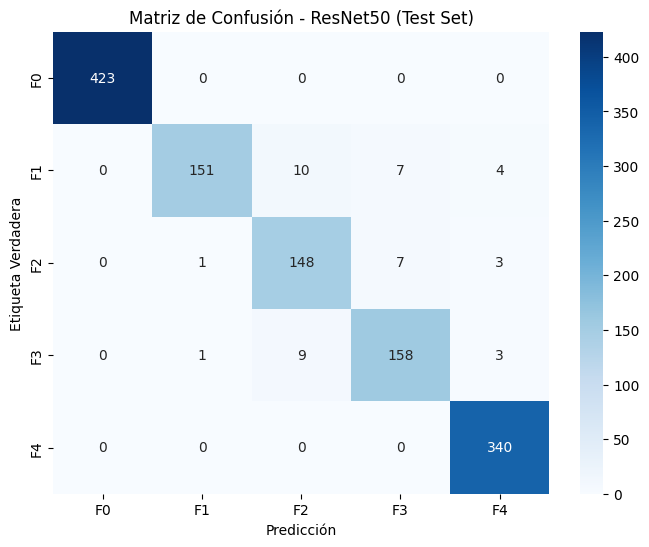

In [ ]:
#Generar la Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_labels)

#Visualizar la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión - ResNet50 (Test Set)')
plt.show()

## Resultados del Modelo ResNet con Fine Tuning

* El modelo logra un rendimiento del 97% en el conjunto de prueba.

* La precisión en el test set es de 0.97, mientras que en el training set es de 1.00. Esta diferencia de 3 puntos porcentuales es mínima, lo que demuestra una generalización del conocimiento de ResNet al dominio de la ecografía hepática.

**Análisis de clases**

* Las clases minoritarias, como F2, tienen un F1-Score de 0.91 (Precision 0.89, Recall 0.93). Esto significa que el modelo es altamente fiable para la detección de fibrosis intermedia, resolviendo el problema de la baja precisión que se veía en el modelo VGG16 (0.67).

## Conclusiones

1. El desarrollo de un modelo basado en ResNet50 con Transfer Learning alcanzó un rendimiento de 97% de precisión, superando el desempeño de métodos no invasivos actuales y estableciendo un nuevo umbral de referencia para el diagnóstico automatizado de fibrosis hepática.

2. La alta precisión en la detección de estadios intermedios (F2,F3) y avanzados (F4) con un F1-Score de 0.91 para F2, esto valida la propuesta de valor del proyecto: proporcionar una herramienta accesible, objetiva y automatizada que pueda discriminar con alta fiabilidad los pacientes que requieren intervención urgente de aquellos que no.

3. Para la aplicación de Deep Learning en la clasificación de imágenes médicas con datasets limitados, el Transfer Learning con preprocesamiento específico de la arquitectura es el enfoque metodológico más robusto y eficaz.


## ----------------------------------------------------------------------------

## **Guardado de modelo ResNet**

In [ ]:
model_resnet.save('resnet_model.keras')
print("model_resnet saved to resnet_model.keras")

model_resnet saved to resnet_model.keras


## Carga del modelo ResNet guardado

In [ ]:
# Carga el modelo
model = load_model('resnet_model.keras', compile=False)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 9,982,981 (38.08 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

## Hacer predicciones con el modelo ResNet cargado

In [ ]:
predictions_loaded_model = model.predict(X_val)
print("First 5 predictions from the loaded model:\n", predictions_loaded_model[:5])

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step
First 5 predictions from the loaded model:
 [[9.9999487e-01 1.3602613e-06 4.9091727e-07 3.2644490e-07 3.0185249e-06]
 [8.5680017e-07 3.3289307e-06 7.7458581e-06 2.4740763e-07 9.9998784e-01]
 [2.1236192e-04 9.9947619e-01 5.3018230e-05 1.1492648e-04 1.4339942e-04]
 [9.9999094e-01 3.8615613e-06 5.5792799e-07 7.4282752e-07 3.8714993e-06]
 [9.9999630e-01 1.1094634e-07 1.4019597e-07 2.3039777e-07 3.1967636e-06]]


In [ ]:
print(model.inputs)
print(model.outputs)

[<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=input_layer_5>]
[<KerasTensor shape=(None, 5), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1493>]


## Resumen

*   El `modelo ResNet` se guardó correctamente en `resnet_model.keras`.
*   El modelo guardado se cargó correctamente desde `resnet_model.keras` a una nueva variable, `model`, con su arquitectura, incluyendo la base `resnet50`, la agrupación y las capas densas, y el recuento de parámetros verificado mediante `summary()`.
*   El `model` se utilizó correctamente para generar predicciones en el conjunto de datos de validación (`X_val`), lo que confirma su funcionalidad.

### Siguientes pasos

*   El guardado, la carga y la predicción exitosa demuestran que el modelo ResNet está listo para su implementación.
*   Los pasos posteriores incluyen la integración del modelo cargado en un entorno de producción para la inferencia en tiempo real.

In [ ]:
!git clone https://github.com/maperezp/Proyecto-DL-Grupo4.git

fatal: destination path 'Proyecto-DL-Grupo4' already exists and is not an empty directory.
